In [2]:
import torch 
import numpy as np

from nltk.tokenize import sent_tokenize 

from pathlib import Path 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.bpe import BPETokenizer 
from mingpt.utils import set_seed 

set_seed(1234)

In [109]:
import importlib
import sentiDataset
importlib.reload(sentiDataset)
from sentiDataset import SentiDataset

In [110]:
#create train and validation dataset using SentiDataset
train_dataset = SentiDataset(split="train") 
val_dataset = SentiDataset(split="validation") 

In [112]:
# Print out an example of the data - this is processed more once it reaches lm_collate_fn (above)
x,y = train_dataset[5]
print(train_dataset[5])
print("X: ",train_dataset.tokenizer.decode(x))
print("Y: ",(y))
print(len(train_dataset))
print(len(val_dataset))
print(train_dataset.get_block_size())

(tensor([26615,  1872,   666, 10147,   220]), tensor(1.))
X:  hawaiian shirt 
Y:  tensor(1.)
960
240
512


In [144]:
#set up the model config and reload the LM trained model
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model_config.n_classification_class = 2
model = GPT(model_config)

model.load_state_dict(torch.load("model_large100K.pt"))
# model.load_state_dict(torch.load("mint.pt",map_location=torch.device('cpu')))
model.eval()

number of parameters: 2.52M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 48)
    (wpe): Embedding(512, 48)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (ln_1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=48, out_features=144, bias=True)
          (c_proj): Linear(in_features=48, out_features=48, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=48, out_features=192, bias=True)
          (c_proj): Linear(in_features=192, out_features=48, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=48, 

In [68]:
#create a NEW collate funciton for batching and preprocessing to train calssifier
def sent_collate_fn(batch, device):
    x = [item[0] for item in batch]  # List (len B) of varying lengths
    y = [item[1] for item in batch]  # List (len B) always 1 label
    maxlen = max([len(s) for s in x])

    padded_x= []
    for sx in x:
        padded_x.append(torch.cat([sx, torch.ones(maxlen - len(sx))]))

    return torch.stack(padded_x).long().to(device), torch.tensor([y]).long().to(device)

In [145]:
def sent_callback(trainer):
    if trainer.iter_num %120 == 0:
        print(f"iter{trainer.iter_num}: train loss {trainer.loss.item():.5f} val loss {trainer.vloss.item():.5f} val accuarcy {trainer.vacc:.5f}")

In [146]:
# Create a Trainer object and set the core hyper-parameters
import mingpt.trainer
importlib.reload(mingpt.trainer)
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 3000  # For small corpus: 3000 iterations is plenty. For large corpus: 100000 iterations is needed
train_config.num_workers = 0
train_config.batch_size = 8   # For small corpus, batch size of 4 is fine.  For large corpus use 16
trainer = Trainer(train_config, model, train_dataset, val_dataset, downstream_finetune=True, collate_fn=sent_collate_fn)
trainer.set_callback('on_batch_end', sent_callback)
trainer.run()

running on device cpu
iter0: train loss 7.50790 val loss 7.45101 val accuarcy 0.62500
iter120: train loss 0.80383 val loss 0.69538 val accuarcy 0.75000
iter240: train loss 1.17110 val loss 0.99701 val accuarcy 0.62500
iter360: train loss 0.21850 val loss 0.81760 val accuarcy 0.25000
iter480: train loss 0.23016 val loss 0.22009 val accuarcy 0.50000
iter600: train loss 0.01794 val loss 0.31651 val accuarcy 0.25000
iter720: train loss 0.00287 val loss 1.13702 val accuarcy 0.37500
iter840: train loss 0.03809 val loss 0.08055 val accuarcy 0.50000
iter960: train loss 0.11417 val loss 0.22911 val accuarcy 0.50000
iter1080: train loss 0.00004 val loss 0.00001 val accuarcy 0.62500
iter1200: train loss 0.00001 val loss 3.25130 val accuarcy 0.25000
iter1320: train loss 0.00000 val loss 0.00000 val accuarcy 0.50000
iter1440: train loss 0.00001 val loss 0.89992 val accuarcy 0.75000
iter1560: train loss 0.00026 val loss 0.01129 val accuarcy 0.50000
iter1680: train loss 0.00000 val loss 0.00000 val a

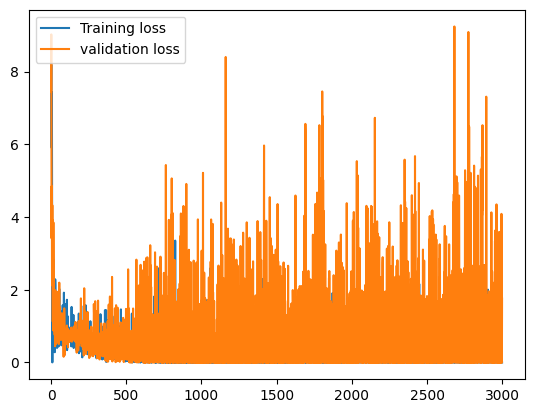

In [147]:
import matplotlib.pyplot as plt
plt.plot(trainer.train_loss, label = "Training loss")
plt.plot(trainer.val_loss, label = "validation loss")
plt.legend()
plt.show()

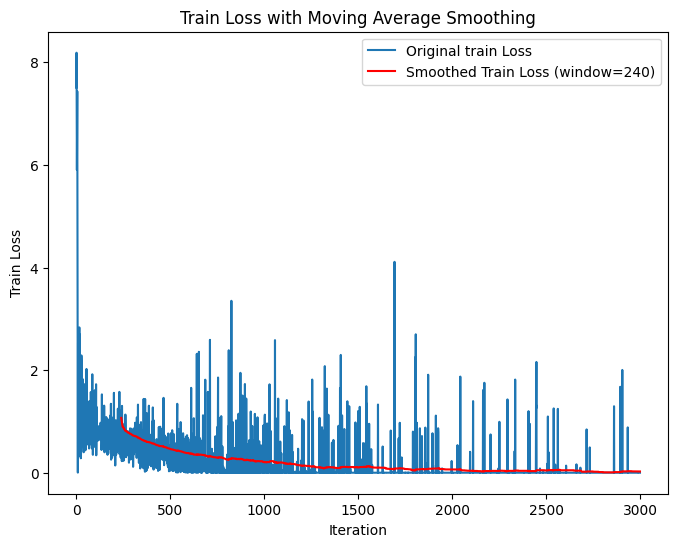

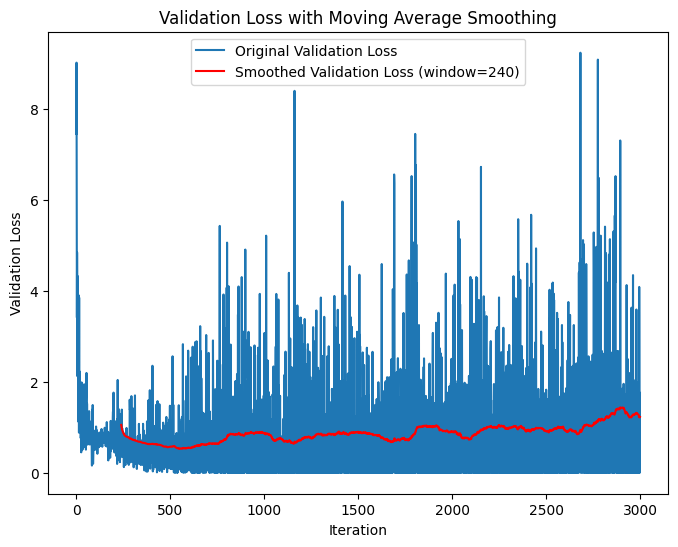

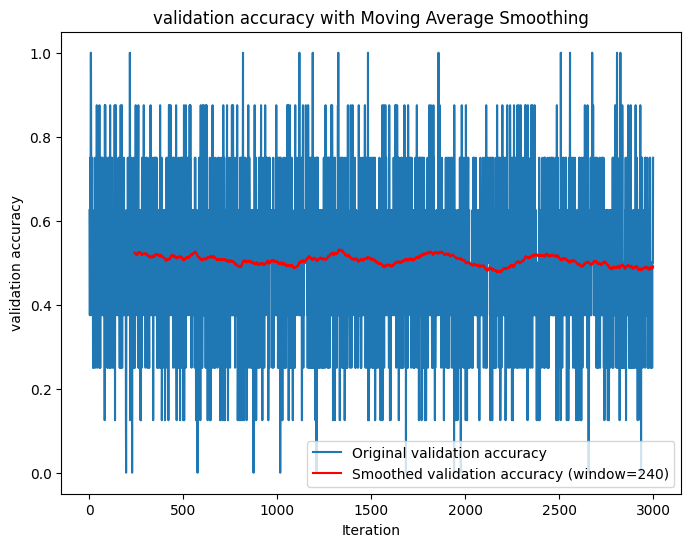

In [151]:
#moving average to smooth the curve
# Calculate moving average
size = 240
def moving_average(data, window_size = 120):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average
smoothed_train_losses = moving_average(trainer.train_loss,size)
smoothed_val_losses = moving_average(trainer.val_loss,size)
smoothed_acc = moving_average(trainer.val_acc,size)

# Plot the original and smoothed validation losses
plt.figure(figsize=(8, 6))
plt.plot(trainer.train_loss, label='Original train Loss')
plt.plot(range(size-1, len(trainer.train_loss)), smoothed_train_losses, label=f'Smoothed Train Loss (window={size})', color='red')
plt.xlabel('Iteration')
plt.ylabel('Train Loss')
plt.title('Train Loss with Moving Average Smoothing')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(trainer.val_loss, label='Original Validation Loss')
plt.plot(range(size-1, len(trainer.val_loss)), smoothed_val_losses, label=f'Smoothed Validation Loss (window={size})', color='red')
plt.xlabel('Iteration')
plt.ylabel('Validation Loss')
plt.title('Validation Loss with Moving Average Smoothing')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(trainer.val_acc, label='Original validation accuracy')
plt.plot(range(size-1, len(trainer.val_acc)), smoothed_acc, label=f'Smoothed validation accuracy (window={size})', color='red')
plt.xlabel('Iteration')
plt.ylabel('validation accuracy')
plt.title('validation accuracy with Moving Average Smoothing')
plt.legend()
plt.show()
